In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Dict, List, Optional, Callable
from scipy.interpolate import interp1d

def normalize(data: pd.Series) -> pd.Series:
    """Normalize data to the range [0, 1]."""
    return (data - data.min()) / (data.max() - data.min())


def smooth(data: pd.Series, window_size: int = 5) -> pd.Series:
    """Smooth data using a rolling window average."""
    return data.rolling(window=window_size, min_periods=1).mean()

def visualize_features_vs_pseudotime_from_csv(
    pseudotime_csv_path: str,
    raw_dir: str,
    y_keys: List[str],
    x_key: str = "pseudotime",
    output_dir: str = "./",
    x_transform: Optional[Dict[str, Any]] = None,
    y_transform: Optional[List[Callable]] = None,
    show_plots: bool = True,
):
    """
    Visualize features (e.g., biomarkers) vs pseudotime with x-axis binning and y-axis transformations.
    """
    # Load pseudotime CSV
    pseudotime_df = pd.read_csv(pseudotime_csv_path)
    pseudotime_df["region_id"] = pseudotime_df["region_id"].astype(str)
    pseudotime_df["cell_id"] = pseudotime_df["cell_id"].astype(str)

    # Initialize aggregated data
    aggregated_data = {x_key: []}
    for y_key in y_keys:
        aggregated_data[y_key] = []

    # Process each region in the pseudotime data
    for region_id in pseudotime_df["region_id"].unique():
        # Load the corresponding raw expression file
        expression_file_path = os.path.join(raw_dir, f"{region_id}.expression.csv")
        if not os.path.exists(expression_file_path):
            print(f"No matching data for region '{region_id}'. Skipping.")
            continue

        expression_df = pd.read_csv(expression_file_path)
        expression_df.rename(columns={"ACQUISITION_ID": "region_id", "CELL_ID": "cell_id"}, inplace=True)
        expression_df["region_id"] = expression_df["region_id"].astype(str)
        expression_df["cell_id"] = expression_df["cell_id"].astype(str)

        # Filter pseudotime data for the current region
        region_df = pseudotime_df[pseudotime_df["region_id"] == region_id]

        # Merge with pseudotime data
        merged_df = region_df.merge(expression_df, on=["region_id", "cell_id"], how="inner")

        # Apply x-axis binning by total number of bins
        if x_transform and x_transform.get("method") == "binning":
            num_bins = x_transform.get("num_bins", 100)
            overlap = x_transform.get("overlap", 0.2)
            min_x, max_x = merged_df[x_key].min(), merged_df[x_key].max()
            bin_width = (max_x - min_x) / num_bins
            step_size = bin_width * (1 - overlap)
            bins = np.arange(min_x, max_x + step_size, step_size)
            merged_df["binned_" + x_key] = pd.cut(merged_df[x_key], bins=bins, labels=False, include_lowest=True)
            binned_key = "binned_" + x_key
        else:
            binned_key = x_key

        # Apply y-axis transformations
        for y_key in y_keys:
            if y_key in merged_df.columns:
                y_data = merged_df[y_key]
                if y_transform:
                    for transform_func in y_transform:
                        y_data = transform_func(y_data)
                merged_df[y_key] = y_data
            else:
                print(f"Feature '{y_key}' not found in region '{region_id}'. Skipping.")

        # Aggregate data by bins
        if binned_key.startswith("binned_"):
            grouped = merged_df.groupby(binned_key).mean(numeric_only=True).reset_index()
        else:
            grouped = merged_df

        # Collect the aggregated results
        for y_key in y_keys:
            if y_key in grouped.columns:
                aggregated_data[x_key].extend(grouped[binned_key] if binned_key.startswith("binned_") else grouped[x_key])
                aggregated_data[y_key].extend(grouped[y_key])
            else:
                aggregated_data[y_key].extend([np.nan] * len(grouped[x_key]))

    # Ensure all arrays in aggregated_data have the same length
    max_length = max(len(values) for values in aggregated_data.values())
    for key, values in aggregated_data.items():
        if len(values) < max_length:
            aggregated_data[key].extend([np.nan] * (max_length - len(values)))

    # Create a DataFrame
    aggregated_df = pd.DataFrame(aggregated_data)

    # Plot data
    plt.figure(figsize=(10, 6))
    for y_key in y_keys:
        if y_key in aggregated_df.columns:
            # Interpolate for smooth plotting
            x_values = aggregated_df[x_key]
            y_values = aggregated_df[y_key]

            # Drop NaN values for interpolation
            valid_indices = ~np.isnan(x_values) & ~np.isnan(y_values)
            x_values = x_values[valid_indices]
            y_values = y_values[valid_indices]

            # Use linear interpolation for smooth plotting
            interpolator = interp1d(x_values, y_values, kind="linear", fill_value="extrapolate")
            x_smooth = np.linspace(x_values.min(), x_values.max(), 500)  # Increase points for smooth curve
            y_smooth = interpolator(x_smooth)

            # Plot the trend
            plt.plot(
                x_smooth,
                y_smooth,
                label=y_key,
                alpha=0.8,
                linestyle="-",
            )

    # Configure the plot
    plt.xlabel(x_key)
    plt.ylabel("Feature Value")
    plt.title("Feature Trends vs Pseudotime")
    plt.legend()
    plt.grid(True)

    # Save and/or display the plot
    output_path = os.path.join(output_dir, "features_vs_pseudotime_continuous.png")
    plt.savefig(output_path)
    if show_plots:
        plt.show()
    print(f"Plot saved to {output_path}")




/opt/anaconda3/envs/TIC/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/opt/anaconda3/envs/TIC/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


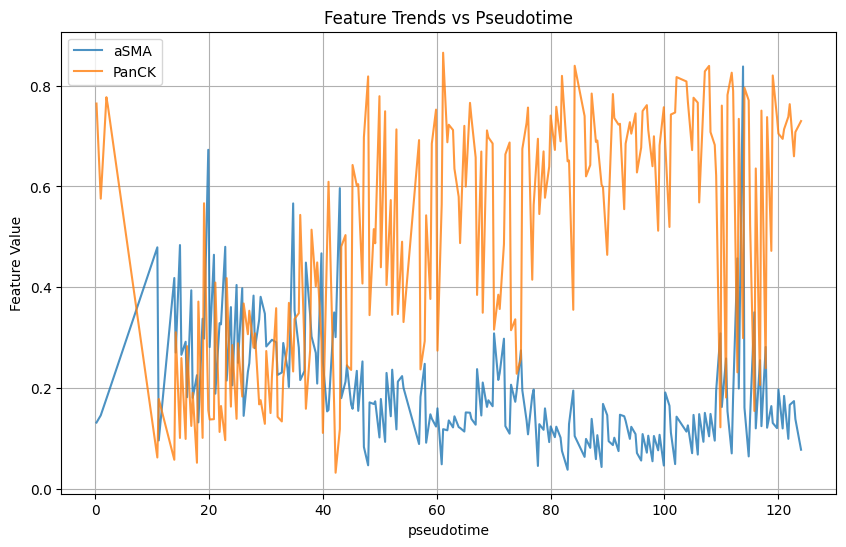

Plot saved to /Users/zhangjiahao/Project/tic/data/example/output/embedding_analysis/composition_vectors/pseudotime/features_vs_pseudotime_continuous.png


In [51]:
visualize_features_vs_pseudotime_from_csv(
    pseudotime_csv_path="/Users/zhangjiahao/Project/tic/data/example/output/embedding_analysis/composition_vectors/pseudotime/start_node_1/pseudotime.csv",
    raw_dir="/Users/zhangjiahao/Project/tic/data/example/voronoi",
    y_keys=["aSMA","PanCK"],
    x_key="pseudotime",
    output_dir="/Users/zhangjiahao/Project/tic/data/example/output/embedding_analysis/composition_vectors/pseudotime",
    x_transform={"method": "binning", "num_bins": 100, "overlap": 0.2},
    y_transform=[normalize],
    show_plots=True
)